In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 1. Elérési út beállítása (hogy megtalálja a src modult)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# 2. Saját modulok importálása
try:
    import config
    from utils import setup_logger, FlagDataset, BaselineLSTM
except ImportError as e:
    print(f"Error importing modules: {e}")
    # Fallback: ha a scriptet közvetlenül a src-ből futtatjuk
    import config
    from utils import setup_logger, FlagDataset, BaselineLSTM

# 3. Logger inicializálása
logger = setup_logger()



In [2]:

def prepare_data(label_path, data_root, output_dir, batch_size, seq_len):
    """
    Betölti az adatokat, spliteli és DataLoader-eket készít.
    """
    logger.info(f"\n[1] DATA PREPARATION...")
    logger.info(f"    Labels: {label_path}")
    logger.info(f"    CSV Data: {data_root}")

    if not os.path.exists(label_path):
        logger.error(f"ERROR: Label file not found: {label_path}")
        return None

    df_labels = pd.read_csv(label_path)

    # Szűrés: Csak azokat tartsuk meg, ahol van generált CSV
    df_labels = df_labels.dropna(subset=['clean_csv_filename'])

    logger.info(f"    -> Total samples: {len(df_labels)}")
    if len(df_labels) < 32:
        logger.error("ERROR: Not enough data for training (<32 samples)!")
        return None

    # Label Encoding
    le = LabelEncoder()
    df_labels['label_idx'] = le.fit_transform(df_labels['label'])

    # Osztálynevek mentése
    classes_path = os.path.join(output_dir, 'classes.npy')
    np.save(classes_path, le.classes_)
    logger.info(f"    -> Classes saved to: {classes_path}")
    logger.info(f"    -> Classes: {le.classes_}")

    # Split (Train / Val)
    train_val, test = train_test_split(df_labels, test_size=0.15, stratify=df_labels['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    # Class Weights számítása
    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Datasets
    # Fontos: data_root a CSV-k helye!
    train_ds = FlagDataset(train, csv_dir=data_root, seq_len=seq_len)
    val_ds = FlagDataset(val, csv_dir=data_root, seq_len=seq_len)

    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return {
        'train': train_loader,
        'val': val_loader,
        'weights': class_weights,
        'num_classes': len(le.classes_)
    }


def train_engine(model, data_package, model_name="baseline_lstm"):
    logger.info(f"\n[2] TRAINING {model_name.upper()} START...")
    logger.info(f"    -> Config: BS={config.BATCH_SIZE}, Seq={config.SEQUENCE_LENGTH}, In={config.INPUT_SIZE}")
    logger.info(f"    -> Model: Hidden={config.HIDDEN_SIZE}, Layers={config.NUM_LAYERS}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"    -> Device: {device}")

    model = model.to(device)

    # Loss & Optimizer
    weights_tensor = torch.tensor(data_package['weights'], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(config.EPOCHS):
        # --- TRAIN LOOP ---
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in data_package['train']:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.CLIP_VALUE)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        # --- VALIDATION LOOP ---
        model.eval()
        val_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for X, y in data_package['val']:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                v_total += y.size(0)
                v_correct += (predicted == y).sum().item()

        # Metrikák
        avg_t_loss = train_loss / len(data_package['train'])
        avg_v_loss = val_loss / len(data_package['val'])

        t_acc = 100 * correct / total if total > 0 else 0
        v_acc = 100 * v_correct / v_total if v_total > 0 else 0

        scheduler.step(avg_v_loss)

        logger.info(
            f"Epoch {epoch + 1}/{config.EPOCHS} | "
            f"Loss: {avg_t_loss:.4f}/{avg_v_loss:.4f} | "
            f"Acc: {t_acc:.1f}%/{v_acc:.1f}% | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # Checkpoint
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            save_path = os.path.join(config.OUTPUT_DIR, f'{model_name}_best.pth')
            torch.save(model.state_dict(), save_path)
            logger.info(f"    -> Model saved! (Acc: {v_acc:.1f}%)")

        # Early Stopping
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config.EARLY_STOPPING_PATIENCE:
                logger.info(f"\n[STOP] Early Stopping triggered after {config.EARLY_STOPPING_PATIENCE} epochs.")
                break

    logger.info("\n[INFO] Training finished.")


Setup kész! Indulhat a kísérletezés.
Adatok betöltve. Train: 386, Val: 83, Classes: 6
Indul a 30 kísérlet futtatása (Early Stopping: 10 epoch)...


Trial 1: Acc=31.33% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.002719968251364204, 'batch_size': 64, 'dropout': 0.2532512392289922, 'gamma': 2.0, 'seq_len': 100}


Trial 2: Acc=32.53% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 4, 'n_heads': 4, 'lr': 0.0007825866835963506, 'batch_size': 64, 'dropout': 0.4930542242706838, 'gamma': 2.0, 'seq_len': 100}


Trial 3: Acc=33.73% | Params={'cnn_filters': 64, 'd_model': 128, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0003065199105326965, 'batch_size': 128, 'dropout': 0.4004197464751854, 'gamma': 1.0, 'seq_len': 50}


Trial 4: Acc=26.51% | Params={'cnn_filters': 64, 'd_model': 64, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.00023856706424205766, 'batch_size': 64, 'dropout': 0.2557014149759215, 'gamma': 2.0, 'seq_len': 50}


Trial 5: Acc=30.12% | Params={'cnn_filters': 64, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.001957282997169991, 'batch_size': 128, 'dropout': 0.4246074738976972, 'gamma': 2.0, 'seq_len': 50}


Trial 6: Acc=33.73% | Params={'cnn_filters': 128, 'd_model': 64, 'transformer_layers': 4, 'n_heads': 4, 'lr': 0.0002333994865062658, 'batch_size': 32, 'dropout': 0.3483604746271026, 'gamma': 1.0, 'seq_len': 50}


Trial 7: Acc=32.53% | Params={'cnn_filters': 128, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.0004586763658944626, 'batch_size': 128, 'dropout': 0.32120933543049074, 'gamma': 1.0, 'seq_len': 50}


Trial 8: Acc=34.94% | Params={'cnn_filters': 32, 'd_model': 64, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.003073554048938109, 'batch_size': 64, 'dropout': 0.27970651258879026, 'gamma': 1.0, 'seq_len': 50}


Trial 9: Acc=33.73% | Params={'cnn_filters': 64, 'd_model': 128, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.00017072409615206946, 'batch_size': 64, 'dropout': 0.3066976351831663, 'gamma': 1.0, 'seq_len': 50}


Trial 10: Acc=30.12% | Params={'cnn_filters': 32, 'd_model': 256, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0014892670626783014, 'batch_size': 64, 'dropout': 0.3851794062109416, 'gamma': 1.0, 'seq_len': 50}


Trial 11: Acc=27.71% | Params={'cnn_filters': 32, 'd_model': 64, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0006067904183422716, 'batch_size': 128, 'dropout': 0.23899843389879832, 'gamma': 1.0, 'seq_len': 50}


Trial 12: Acc=30.12% | Params={'cnn_filters': 64, 'd_model': 128, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0003752184138139535, 'batch_size': 64, 'dropout': 0.2705323942285071, 'gamma': 2.0, 'seq_len': 100}


Trial 13: Acc=37.35% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.0025034576809543057, 'batch_size': 32, 'dropout': 0.22053418594563268, 'gamma': 1.0, 'seq_len': 100}


Trial 14: Acc=31.33% | Params={'cnn_filters': 128, 'd_model': 256, 'transformer_layers': 4, 'n_heads': 4, 'lr': 0.0015752426437277178, 'batch_size': 128, 'dropout': 0.24748887321549906, 'gamma': 2.0, 'seq_len': 100}


Trial 15: Acc=22.89% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.0029633381856300632, 'batch_size': 32, 'dropout': 0.3922831283194885, 'gamma': 2.0, 'seq_len': 100}


Trial 16: Acc=31.33% | Params={'cnn_filters': 128, 'd_model': 256, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0029389308156392534, 'batch_size': 32, 'dropout': 0.38720365493917563, 'gamma': 2.0, 'seq_len': 100}


Trial 17: Acc=20.48% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.00021484987092014964, 'batch_size': 64, 'dropout': 0.26616241118912337, 'gamma': 2.0, 'seq_len': 100}


Trial 18: Acc=33.73% | Params={'cnn_filters': 64, 'd_model': 128, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0004358011786989118, 'batch_size': 128, 'dropout': 0.38559203626727395, 'gamma': 2.0, 'seq_len': 50}


Trial 19: Acc=44.58% | Params={'cnn_filters': 128, 'd_model': 128, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0004430278114661143, 'batch_size': 64, 'dropout': 0.21973649737515427, 'gamma': 1.0, 'seq_len': 100}


Trial 20: Acc=30.12% | Params={'cnn_filters': 128, 'd_model': 256, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0003045664337929548, 'batch_size': 64, 'dropout': 0.3565690700456492, 'gamma': 2.0, 'seq_len': 100}


Trial 21: Acc=27.71% | Params={'cnn_filters': 128, 'd_model': 256, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.00136517970338544, 'batch_size': 128, 'dropout': 0.4613515302997914, 'gamma': 2.0, 'seq_len': 50}


Trial 22: Acc=18.07% | Params={'cnn_filters': 128, 'd_model': 64, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.00015350470910983826, 'batch_size': 128, 'dropout': 0.49739559967193586, 'gamma': 1.0, 'seq_len': 50}


Trial 23: Acc=38.55% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.000524766133998591, 'batch_size': 32, 'dropout': 0.37371940722955077, 'gamma': 2.0, 'seq_len': 100}


Trial 24: Acc=40.96% | Params={'cnn_filters': 128, 'd_model': 64, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0012458894638809517, 'batch_size': 32, 'dropout': 0.20951745660599713, 'gamma': 2.0, 'seq_len': 50}


Trial 25: Acc=31.33% | Params={'cnn_filters': 128, 'd_model': 64, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.00046867265988272583, 'batch_size': 64, 'dropout': 0.45413864655491315, 'gamma': 1.0, 'seq_len': 50}


Trial 26: Acc=40.96% | Params={'cnn_filters': 32, 'd_model': 256, 'transformer_layers': 4, 'n_heads': 4, 'lr': 0.00012989832331012816, 'batch_size': 32, 'dropout': 0.24772509321010966, 'gamma': 1.0, 'seq_len': 100}


Trial 27: Acc=20.48% | Params={'cnn_filters': 64, 'd_model': 64, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0001443284288199332, 'batch_size': 32, 'dropout': 0.2766823452051868, 'gamma': 2.0, 'seq_len': 100}


Trial 28: Acc=25.30% | Params={'cnn_filters': 128, 'd_model': 128, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0005940954172690288, 'batch_size': 128, 'dropout': 0.30013922489864037, 'gamma': 2.0, 'seq_len': 100}


Trial 29: Acc=24.10% | Params={'cnn_filters': 32, 'd_model': 128, 'transformer_layers': 2, 'n_heads': 4, 'lr': 0.00011713556980627396, 'batch_size': 32, 'dropout': 0.4061220056782208, 'gamma': 1.0, 'seq_len': 100}


Trial 30: Acc=34.94% | Params={'cnn_filters': 128, 'd_model': 256, 'transformer_layers': 3, 'n_heads': 4, 'lr': 0.0010866809944754508, 'batch_size': 32, 'dropout': 0.22725627883273913, 'gamma': 1.0, 'seq_len': 50}

=== LEGJOBB 3 KONFIGURÁCIÓ ===
    cnn_filters  d_model  transformer_layers  n_heads        lr  batch_size  \
18          128      128                   3        4  0.000443          64   
23          128       64                   3        4  0.001246          32   
25           32      256                   4        4  0.000130          32   

     dropout  gamma  seq_len  trial_id   accuracy  
18  0.219736    1.0      100        19  44.578313  
23  0.209517    2.0       50        24  40.963855  
25  0.247725    1.0      100        26  40.963855  


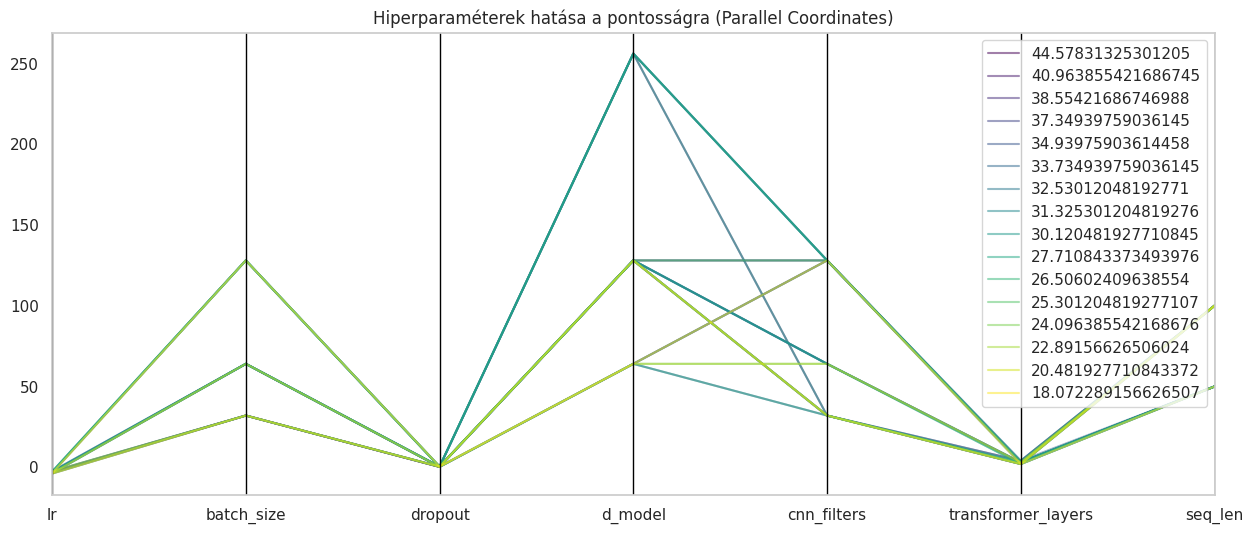

Tipp: A sötétebb/sárgább vonalak mutatják a magasabb pontosságot.


In [6]:
# ==========================================
# 1. SETUP & IMPORTOK
# ==========================================
import sys
import os
import random
import logging
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# JAVÍTÁS: Sima tqdm használata a notebook verzió helyett (ez stabilabb)
from tqdm import tqdm

# JAVÍTÁS: Warningok elnyomása (hogy a PyTorch ne szemetelje tele a kimenetet)
import warnings
warnings.filterwarnings("ignore")

# Path beállítása
project_root = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Saját modulok
try:
    import config
    from utils import setup_logger, FlagDataset, HybridModel, FocalLoss
except ImportError:
    if 'src' not in sys.path: sys.path.append('src')
    import config
    from utils import setup_logger, FlagDataset, HybridModel, FocalLoss

# Logger
logger = setup_logger()
logger.setLevel(logging.WARNING)

print("Setup kész! Indulhat a kísérletezés.")

# ==========================================
# 2. ADATOK BETÖLTÉSE
# ==========================================
def load_and_prep_data():
    label_path = config.LABEL_FILE
    if not os.path.exists(label_path):
        print(f"HIBA: Nem található a label fájl itt: {label_path}")
        return None, None, None, None

    df = pd.read_csv(label_path)
    df = df.dropna(subset=['clean_csv_filename'])

    allowed = ['EURUSD', 'XAU']
    mask = df['clean_csv_filename'].apply(lambda x: any(a in str(x).upper() for a in allowed))
    df = df[mask].reset_index(drop=True)

    le = LabelEncoder()
    df['label_idx'] = le.fit_transform(df['label'])

    train_val, _ = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
    train, val = train_test_split(train_val, test_size=0.176, stratify=train_val['label'], random_state=42)

    y_train = train['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    return train, val, class_weights, len(le.classes_)

train_df, val_df, class_weights, num_classes = load_and_prep_data()

if train_df is not None:
    print(f"Adatok betöltve. Train: {len(train_df)}, Val: {len(val_df)}, Classes: {num_classes}")
else:
    print("HIBA: Az adatok betöltése sikertelen.")

# ==========================================
# 3. KERESÉSI TÉR (JAVÍTVA)
# ==========================================
def get_random_params():
    return {
        'cnn_filters': random.choice([32, 64, 128]),
        'd_model': random.choice([64, 128, 256]),
        'transformer_layers': random.choice([2, 3, 4]),
        'n_heads': 4,
        'lr': 10 ** random.uniform(-4, -2.5),
        'batch_size': random.choice([32, 64, 128]),
        # JAVÍTÁS: A random.uniform csak 2 paramétert vár (min, max)
        'dropout': random.uniform(0.2, 0.5),
        'gamma': random.choice([1.0, 2.0]),
        'seq_len': random.choice([50, 100])
    }

# ==========================================
# 4. KÍSÉRLETI MOTOR (EARLY STOPPINGGAL)
# ==========================================
def run_trial(trial_id, params, epochs=50, patience=10): # <-- Patience paraméter
    # Datasetek
    train_ds = FlagDataset(train_df, config.DATA_ROOT, seq_len=params['seq_len'], augment=True)
    val_ds = FlagDataset(val_df, config.DATA_ROOT, seq_len=params['seq_len'], augment=False)

    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'], shuffle=False)

    # Modell
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = HybridModel(
        input_size=config.INPUT_SIZE,
        num_classes=num_classes,
        d_model=params['d_model'],
        nhead=params['n_heads'],
        num_layers=params['transformer_layers'],
        dim_feedforward=params['d_model'] * 2,
        dropout=params['dropout'],
        cnn_filters=params['cnn_filters']
    ).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = FocalLoss(alpha=weights_tensor, gamma=params['gamma'])

    best_val_acc = 0.0
    best_val_loss = float('inf') # Early stoppinghoz kell a Loss figyelése
    patience_counter = 0         # Számláló

    # Progress bar
    pbar = tqdm(range(epochs), desc=f"Trial {trial_id}", leave=False)

    for epoch in pbar:
        # --- TRAIN ---
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # --- VALIDATION ---
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0 # Loss gyűjtése

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)

                # Loss számítása
                loss = criterion(out, y)
                val_loss += loss.item()

                # Pontosság számítása
                _, pred = torch.max(out.data, 1)
                total += y.size(0)
                correct += (pred == y).sum().item()

        # Átlagok
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        # Legjobb pontosság mentése (ez a visszatérési érték)
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        # --- EARLY STOPPING LOGIKA ---
        # Ha a Loss csökken, jók vagyunk -> reset
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            # Ha a Loss nő vagy stagnál -> növeljük a számlálót
            patience_counter += 1

        # Progress bar frissítése
        pbar.set_postfix({'Best Acc': f"{best_val_acc:.1f}%", 'Patience': f"{patience_counter}/{patience}"})

        # Ha elfogyott a türelem, kilépünk a ciklusból
        if patience_counter >= patience:
            break

    return best_val_acc

# ==========================================
# 5. A NAGY FUTTATÁS
# ==========================================
if train_df is not None:
    N_TRIALS = 30
    results = []

    print(f"Indul a {N_TRIALS} kísérlet futtatása (Early Stopping: 10 epoch)...")

    for i in range(1, N_TRIALS + 1):
        params = get_random_params()
        try:
            # Most már 50 epochot engedünk neki, de az Early Stopping hamarabb leállíthatja
            acc = run_trial(i, params, epochs=50, patience=10)

            res_entry = params.copy()
            res_entry['trial_id'] = i
            res_entry['accuracy'] = acc
            results.append(res_entry)

            print(f"Trial {i}: Acc={acc:.2f}% | Params={params}")

        except Exception as e:
            print(f"Trial {i} HIBA: {e}")
            import traceback
            traceback.print_exc()

    if len(results) > 0:
        df_results = pd.DataFrame(results)
        df_results = df_results.sort_values(by='accuracy', ascending=False)

        print("\n=== LEGJOBB 3 KONFIGURÁCIÓ ===")
        print(df_results.head(3))

        # ==========================================
        # 6. VIZUALIZÁCIÓ
        # ==========================================
        try:
            sns.set(style="whitegrid")
            plt.rcParams['figure.figsize'] = (15, 10)

            # Parallel Coordinates
            from pandas.plotting import parallel_coordinates
            cols = ['lr', 'batch_size', 'dropout', 'd_model', 'cnn_filters', 'transformer_layers', 'seq_len', 'accuracy']
            df_plot = df_results[cols].copy()
            df_plot['lr'] = np.log10(df_plot['lr'])

            plt.figure(figsize=(15, 6))
            plt.title("Hiperparaméterek hatása a pontosságra (Parallel Coordinates)")
            parallel_coordinates(df_plot, 'accuracy', colormap=plt.get_cmap("viridis"), alpha=0.5)
            plt.show()

            print("Tipp: A sötétebb/sárgább vonalak mutatják a magasabb pontosságot.")

        except Exception as e:
            print(f"Hiba a plotozásnál: {e}")
    else:
        print("Nem születtek eredmények a hibák miatt.")